In [1]:
from itertools import cycle
import matplotlib.pyplot as plt
from numpy import interp
from sklearn.datasets import make_classification
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score
import os
import xgboost as xgb
from sklearn.preprocessing import label_binarize

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

D:\anaconda\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
def plotROC(n_classes,y_test,y_score):
    # 计算
    fpr, tpr, thread = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    # 绘图
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('roc.png',)
    plt.show()

# 计算准确率
def calculate_all_prediction(confMatrix):
    '''
    计算总精度,对角线上所有值除以总数
    :return:
    '''
    total_sum = confMatrix.sum()
    correct_sum = (np.diag(confMatrix)).sum()
    prediction = round(100 * float(correct_sum) / float(total_sum), 2)
    print('准确率:' + str(prediction) + '%')


def calculae_lable_prediction(confMatrix):
    '''
    计算每一个类别的预测精度:该类被预测正确的数除以该类的总数
    '''
    l = len(confMatrix)
    for i in range(l):
        label_total_sum = confMatrix.sum(axis=1)[i]
        label_correct_sum = confMatrix[i][i]
        prediction = round(100 * float(label_correct_sum) / float(label_total_sum), 2)
        print('精确率: {0} : {1} %'.format(i, prediction))

def calculate_label_recall(confMatrix):
    l = len(confMatrix)
    for i in range(l):
        label_total_sum = confMatrix.sum(axis=0)[i]
        label_correct_sum = confMatrix[i][i]
        prediction = round(100 * float(label_correct_sum) / float(label_total_sum), 2)
        print('召回率: {0} : {1} %'.format(i, prediction))

In [3]:
file = '代谢组数据 - 填充 by min - 副本1.csv'
df = pd.read_csv(file,engine='python')
features=df.columns.tolist()

feat_labels = df.columns[5:]
X=df[features[5:]]
y=df[features[4]]

pd.DataFrame(X)
pd.DataFrame(y)
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2)

XGB结果

特征排序结果——————————————————————————————————————————————————
 1) Erythose 4-phosphate           0.165393
 2) Putrescine                     0.109716
 3) LPC(20:4)                      0.046074
 4) Histamine                      0.040215
 5) MG(18:0)                       0.039459
 6) LPC(16:0)                      0.037344
 7) 3-Methoxytyrosine              0.034131
 8) PC(36:2)                       0.032964
 9) Cystine                        0.031414
10) PC(40:6)                       0.027214
11) SM(d18:1/24:0)                 0.026636
12) Ascorbate                      0.021892
13) LPG(18:1)                      0.021215
14) PE(36:2)                       0.019925
15) CE(18:1)                       0.019337
16) PEth(16:0_18:1)                0.017987
17) PI(18:0_18:1)                  0.017935
18) LPG(16:0)                      0.016719
19) PG(16:0_20:4)                  0.016254
20) PE(O-18:0/22:6)                0.015182
21) 5-Hydroxytryptophan            0.014867
22) 7-alpha-Hydroxy

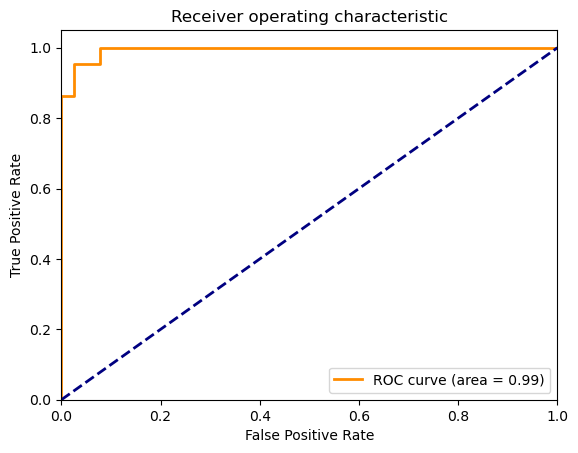

交叉验证得分：
[0.92       1.         0.91666667 0.95833333 0.875      0.875
 0.95833333 0.95833333 0.95833333 0.95833333]
0.9378333333333334


In [4]:
model = xgb.XGBClassifier( learning_rate =0.1,
 n_estimators=200,
 max_depth=5)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score[:,1])

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

RF结果

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.3s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      |

特征排序结果——————————————————————————————————————————————————
 1) Putrescine                     0.171733
 2) PG(16:0_20:4)                  0.076245
 3) Dopamine 4-o-sulfate           0.041364
 4) LPG(16:0)                      0.035777
 5) Erythose 4-phosphate           0.033828
 6) Ascorbate                      0.033216
 7) PA(18:1/18:1)                  0.025389
 8) MG(18:0)                       0.024118
 9) LPG(18:0)                      0.021413
10) 3-Hydroxybutyric acid          0.017133
11) Histamine                      0.016106
12) 7-Methylxanthine               0.014739
13) Oxoglutaric acid               0.014332
14) Dopa                           0.012603
15) LPC(16:0)                      0.010909
16) Glutathione                    0.009670
17) LPC(16:1)                      0.008915
18) LPE(16:0)                      0.008635
19) LPE(18:0)                      0.008612
20) Dopamine 3-o-sulfate           0.007952
21) PC(O-18:0/2:0)                 0.007030
22) LPC(26:1)      

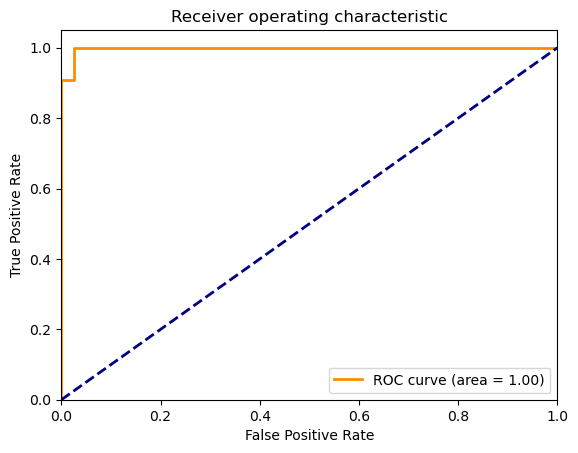

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 174 tasks      | elapsed:    2.1s
[Parallel(n_jobs=2)]: Done 197 out of 200 | elapsed:    2.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    2.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Usi

交叉验证得分：
[0.96       1.         0.91666667 0.95833333 0.875      0.875
 0.95833333 0.95833333 0.95833333 0.95833333]
0.9418333333333335


[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 200 out of 200 | elapsed:    0.0s finished


In [5]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(criterion='gini',max_features=25,n_estimators=200,random_state=1,n_jobs=2,verbose=1)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score[:,1])

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

SVM

特征排序结果——————————————————————————————————————————————————
(238,)
(238,)
 1) Oxoglutaric acid               1.679549
 2) (3-O-sulfo)GalCer(d18:1/24:1(2OH)) 1.531175
 3) TG(20:4_36:2)                  1.449196
 4) SM(d18:1/24:0)                 1.335437
 5) LacCer(d18:1/16:0)             1.286361
 6) PI(16:0_18:1)                  1.176545
 7) Putrescine                     1.109582
 8) GM3(d36:1)                     1.057134
 9) PC(40:5)                       1.008388
10) PE(38:5)                       1.003247
11) PE(P-18:0/22:6)                0.995745
12) DG(18:0_20:4)                  0.972229
13) PI(18:1/18:1)                  0.952461
14) LPC(16:1)                      0.944477
15) LPC(18:0)                      0.855657
16) PE(40:7)                       0.829441
17) LPC(20:4)                      0.813977
18) GB3(d18:1/24:1)                0.772929
19) PE(P-16:0/22:4)                0.751796
20) CL(72:8-2(OOH)/18:2)           0.711276
21) 7-Methylxanthine               0.693650
2

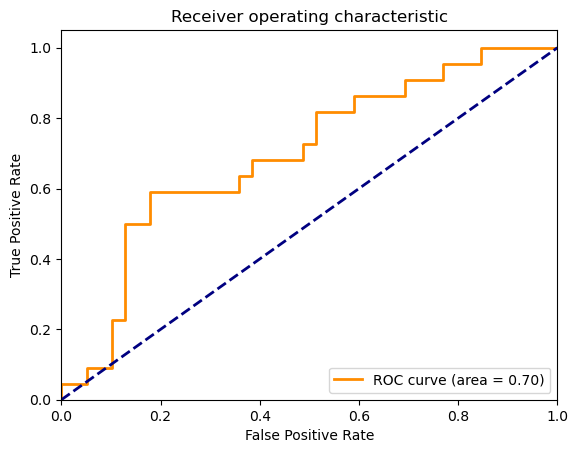

交叉验证得分：
[0.64       0.52       0.66666667 0.625      0.70833333 0.83333333
 0.54166667 0.58333333 0.79166667 0.58333333]
0.6493333333333334


In [6]:
from sklearn import svm
model = svm.SVC(kernel = 'linear')
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
coef = model.coef_
coef = np.abs(coef)
importances = np.sum(coef, axis=0)
indices = np.argsort(importances)[::-1] # 下标排序
print(importances.shape)
print(indices.shape)
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.decision_function(X_test)
print(y_score)
plotROC(3,Y_test,y_score)

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())


Cart

特征排序结果——————————————————————————————————————————————————
 1) Putrescine                     0.506122
 2) Erythose 4-phosphate           0.246939
 3) Histamine                      0.071692
 4) Cystine                        0.045279
 5) GM3(d36:1)                     0.024498
 6) PG(18:1/18:1)                  0.020601
 7) LPC(20:4)                      0.019788
 8) EPA                            0.016560
 9) PC(36:2)                       0.016334
10) 1-Methylxanthine               0.011432
11) DG(16:0_20:4)                  0.011432
12) LacCer(d18:1/16:0)             0.009323
13) CE(20:4)                       0.000000
14) Cholesteryl hexoside           0.000000
15) Cer(d18:1/24:0)                0.000000
16) Cer(d18:1/18:0)                0.000000
17) Cer(d18:1/16:0)                0.000000
18) Coenzyme Q10                   0.000000
19) CE(22:6)                       0.000000
20) DG(16:0_18:1)                  0.000000
21) CE(20:5)                       0.000000
22) Cer(d18:1/24:1)

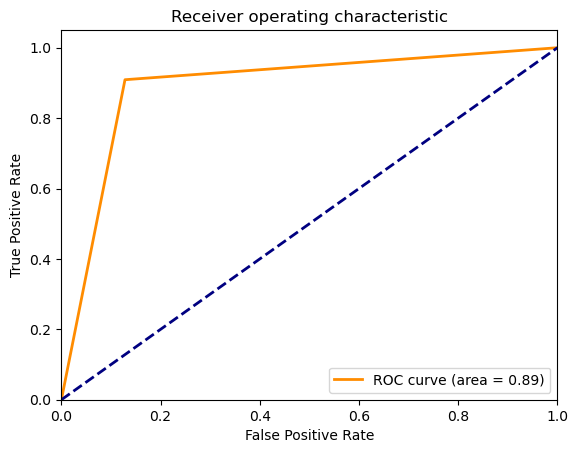

交叉验证得分：
[0.92       0.92       0.91666667 0.875      0.875      0.91666667
 0.91666667 0.875      0.95833333 0.83333333]
0.9006666666666667


In [7]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=42)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score[:,1])

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

GBM

特征排序结果——————————————————————————————————————————————————
 1) Putrescine                     0.506122
 2) Erythose 4-phosphate           0.161571
 3) MG(18:0)                       0.085371
 4) Histamine                      0.066608
 5) Cystine                        0.045077
 6) EPA                            0.021400
 7) LPC(20:4)                      0.014714
 8) PG(18:1/18:1)                  0.014291
 9) (3-O-sulfo)GalCer(d18:1/18:0(2OH) 0.010133
10) GM3(d36:1)                     0.007768
11) LPC(16:0)                      0.007122
12) PC(36:2)                       0.006405
13) LacCer(d18:1/16:0)             0.006101
14) CE(20:4)                       0.004924
15) PE(38:6)                       0.004094
16) GD1a/b(d36:1)                  0.003952
17) Dopamine 3-o-sulfate           0.002926
18) PC(40:6)                       0.002811
19) Stearoylcarnitine              0.002142
20) 1-Methylxanthine               0.002133
21) Glutathione                    0.002071
22) PI(16:0_20:4

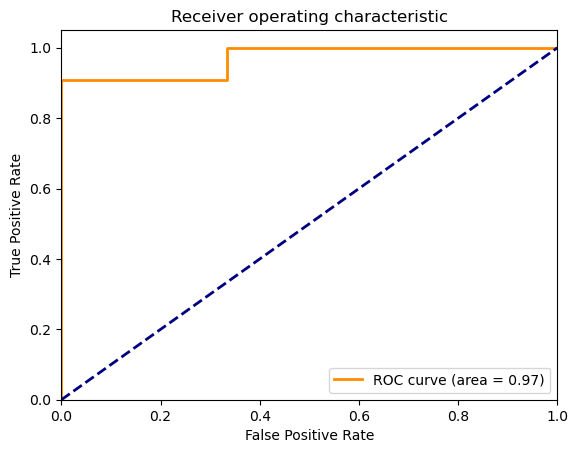

交叉验证得分：
[0.92       0.96       0.91666667 0.91666667 0.875      0.91666667
 0.95833333 0.91666667 0.95833333 0.875     ]
0.9213333333333333


In [8]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 下标排序
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.predict_proba(X_test)
plotROC(3,Y_test,y_score[:,1])

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())

逻辑回归

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


特征排序结果——————————————————————————————————————————————————
(238,)
(238,)
 1) LPC(16:0)                      0.227141
 2) Cer(d18:1/24:1)                0.225702
 3) Threonine                      0.127767
 4) DG(18:1/18:1)                  0.125514
 5) TG(18:1_34:2)                  0.112906
 6) PI(18:0_20:4)                  0.112520
 7) PE(P-16:0/20:4)                0.101236
 8) Lactic acid                    0.094083
 9) SM(d18:1/16:0)                 0.091408
10) DG(18:0_22:6)                  0.089269
11) PE(36:2)                       0.088849
12) TG(18:1_34:3)                  0.080991
13) PC(36:2)                       0.076893
14) LPC(18:0)                      0.076276
15) CE(16:1)                       0.076247
16) Serine                         0.070693
17) Pyroglutamic acid              0.065468
18) Succinic acid                  0.060687
19) PE(P-18:0/18:1)                0.054834
20) Sphinganine                    0.052497
21) SM(d18:1/24:0)                 0.052036
22) c

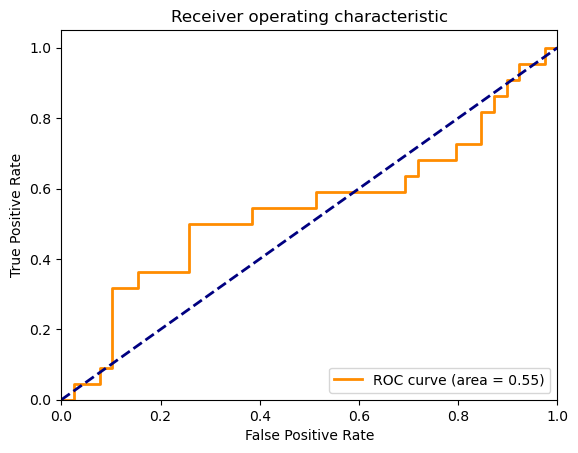

D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

交叉验证得分：
[0.64       0.64       0.79166667 0.625      0.75       0.875
 0.58333333 0.58333333 0.54166667 0.66666667]
0.6696666666666667


D:\anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(random_state=0)
model.fit(X_train, Y_train)
score = model.score(X_test, Y_test)
print("特征排序结果——————————————————————————————————————————————————")
coef = model.coef_
coef = np.abs(coef)
importances = np.sum(coef, axis=0)
indices = np.argsort(importances)[::-1] # 下标排序
print(importances.shape)
print(indices.shape)
for f in range(X_train.shape[1]):   # x_train.shape[1]=13
    print("%2d) %-*s %f" % \
          (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))
predictions=model.predict(X_test)
cm = confusion_matrix(y_true=Y_test, y_pred=predictions)
calculate_all_prediction(cm)
calculae_lable_prediction(cm)
calculate_label_recall(cm)
y_score = model.decision_function(X_test)
plotROC(3,Y_test,y_score)

scores = cross_val_score(model, X_train, Y_train, cv=10)  #cv为迭代次数。
print("交叉验证得分：")
print(scores)
print(scores.mean())